# EDA for the Emotion Image Dataset

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Constants
DATASET_DIR = "../../data/raw/fer2013/train"
EXPECTED_SIZE = (48, 48)

# Storage - for storing attributes
class_counts = {}
brightness_vals = []
small_images = []
invalid_modes = []
corrupted_files = []
sample_images = []



## Scan all image files

In [13]:
from tqdm.notebook import tqdm

sample_counts = {}

print("Scanning dataset... 🔍")
for original_class in tqdm(os.listdir(DATASET_DIR), desc="Classes"):
    class_path = os.path.join(DATASET_DIR, original_class)
    if not os.path.isdir(class_path):
        continue

    sample_counts.setdefault(original_class, 0)
    file_list = os.listdir(class_path)
    class_counts[original_class] = len(file_list)

    for file_name in tqdm(file_list, desc=f"{original_class}", leave=False):
        fpath = os.path.join(class_path, file_name)
        try:
            with Image.open(fpath) as img:
                img = img.convert("L")  # Grayscale
                img_resized = img.resize(EXPECTED_SIZE)
                brightness_vals.append(np.mean(img_resized))

                # Collect samples for visualizations later
                if sample_counts[original_class] < 3:
                    sample_images.append((original_class, img_resized))
                    sample_counts[original_class] += 1

                # Flag small images
                if img.size[0] < 32 or img.size[1] < 32:
                    small_images.append(fpath)

                # Flag images with different color modes
                if img.mode not in ["L", "RGB"]:
                    invalid_modes.append((fpath, img.mode))

        except Exception as e:
            corrupted_files.append((fpath, str(e)))

print("Dataset Scanning Success.. ✅")

Scanning dataset... 🔍


Classes:   0%|          | 0/7 [00:00<?, ?it/s]

angry:   0%|          | 0/3995 [00:00<?, ?it/s]

disgust:   0%|          | 0/436 [00:00<?, ?it/s]

fear:   0%|          | 0/4097 [00:00<?, ?it/s]

happy:   0%|          | 0/7215 [00:00<?, ?it/s]

neutral:   0%|          | 0/4965 [00:00<?, ?it/s]

sad:   0%|          | 0/4830 [00:00<?, ?it/s]

surprise:   0%|          | 0/3171 [00:00<?, ?it/s]

Dataset Scanning Success.. ✅


## Plots

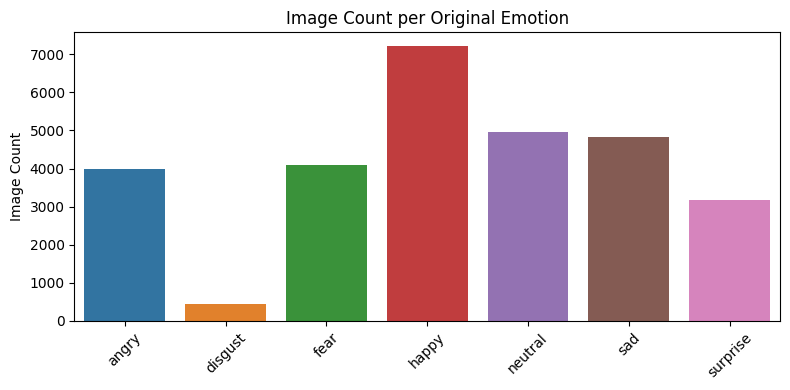

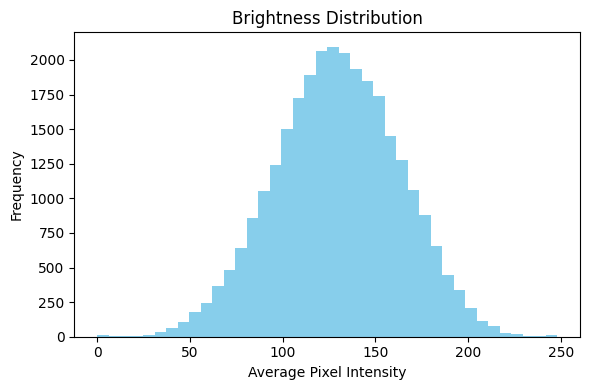

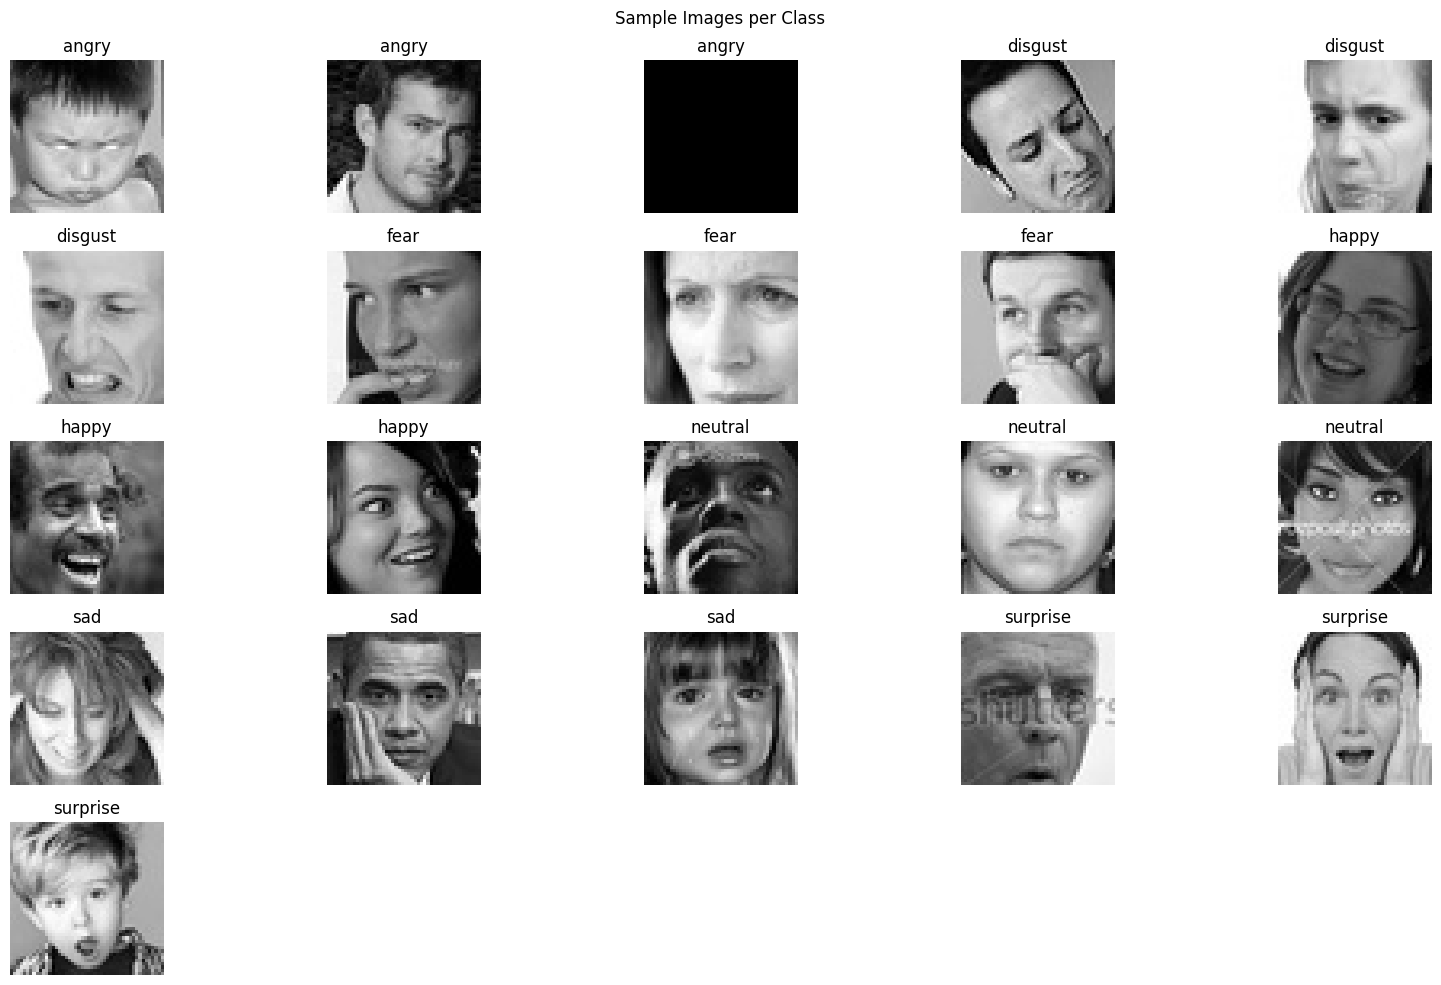

In [19]:
# Class distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Image Count per Original Emotion")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Brightness histogram
plt.figure(figsize=(6, 4))
plt.hist(brightness_vals, bins=40, color='skyblue')
plt.title("Brightness Distribution")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Sample images
plt.figure(figsize=(16, 10))
num_samples = len(sample_images)
cols = 5
rows = (num_samples + cols - 1) // cols

for i, (label, img) in enumerate(sample_images):
    plt.subplot(rows, cols, i + 1)
    if isinstance(img, Image.Image):
        plt.imshow(np.array(img), cmap='gray')
    else:
        plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.suptitle("Sample Images per Class")
plt.tight_layout()
plt.show()

# Small images per class
if small_images:
    small_class_counts = {}
    for path in small_images:
        cls = os.path.basename(os.path.dirname(path))
        small_class_counts[cls] = small_class_counts.get(cls, 0) + 1

    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(small_class_counts.keys()), y=list(small_class_counts.values()))
    plt.title("Small Images (<32x32) per Class")
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Invalid mode images per class
if invalid_modes:
    mode_class_counts = {}
    for path, mode in invalid_modes:
        cls = os.path.basename(os.path.dirname(path))
        key = f"{cls} ({mode})"
        mode_class_counts[key] = mode_class_counts.get(key, 0) + 1

    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(mode_class_counts.keys()), y=list(mode_class_counts.values()))
    plt.title("Non-Standard Color Modes per Class")
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



## Summary

In [15]:
print("\n[Summary Report]")
print(f"Total classes: {len(class_counts)}")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} images")

print(f"\nCorrupted files: {len(corrupted_files)}")
if corrupted_files:
    print("  Example:", corrupted_files[0])

print(f"Images smaller than 32x32: {len(small_images)}")
print(f"Non-standard modes: {len(invalid_modes)}")



[Summary Report]
Total classes: 7
  angry: 3995 images
  disgust: 436 images
  fear: 4097 images
  happy: 7215 images
  neutral: 4965 images
  sad: 4830 images
  surprise: 3171 images

Corrupted files: 0
Images smaller than 32x32: 0
Non-standard modes: 0


## Conclusion

- ⚠️ Class distribution is imbalanced. The `happy` class dominates with 7,215 images, while `disgust` has only 436 — too few for meaningful training.
- ⚠️ Some images are poor quality (e.g., fully black or watermarked), which could negatively impact model performance.
- ✅ Brightness distribution appears normal, suggesting consistent lighting conditions across the dataset.
- ✅ No critical corruption issues found in the dataset.

### Reccomonded Actions:

- **Removed the `disgust` class** due to low sample.
- **Merged the `angry` class into a new `stressed` class**, creating a more meaningful emotional cay.
- **Downsampled the `happy` class** to balance it with the other classes (from 7,215 → 0).
- Will remove poor-quality images during preprocessing (e.g., black/watermarked, no face detected).

## final emotion classes (Moods):
- `happy`
- `sad`
- `stressed` (merged from `angry`)
- `fear`
- `neutral`
- `surprise`\`